<a href="https://colab.research.google.com/github/smaciasg/DataScience2022-3/blob/main/Introducci%C3%B3n_al_ejercicio_de_pr%C3%A1ctica_de_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En esta tarea lo que harán es:

1. Importar y preparar un conjunto de datos para la modelización
probar y evaluar 3 diferentes modelos de boosting y comparar los tiempos de ajuste de cada uno.
2. Afinar los hiperparámetros del mejor modelo para reducir el sobreajuste y mejorar el rendimiento.

Para esta tarea utilizarán este datos del censo.  **El objetivo es predecir si una persona ganará más dinero o menos de $50 000 al año en ingresos**.  Encontrarán el código de inicio y las preguntas para esta tarea en este cuaderno de Colab.  Hagan una copia del cuaderno y agregue el código adecuado y comentarios. 

###**1) Importar las bibliotecas y librerías necesarias**

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Librerías para preprocesamiento
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
# Librería para el modelo
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
#Métricas
from sklearn.metrics import roc_auc_score,accuracy_score, classification_report, plot_confusion_matrix
#Optimizador
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

###**2) Cargar datos y explorarlos**

In [2]:
df_census = pd.read_csv('/content/drive/MyDrive/CODING DOJO/DATA SCIENCE/ACTIVIDADES SEMANA 7 - MODELOS DE PREDICCIÓN CLASIFICACIÓN/census_income - census_income.csv')
df_census.head()

,Unnamed: 0,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income-class
0,0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [3]:
df_census.info()
#1. Se observa que la columna Unnamed:0 es un ID por lo que puede ser eliminada
#2. Hay columnas tipo objeto, se debene analizar para determinar si debería haber alguna prioridad en las etiquetas o no, si no se usa un OneHotEncoder.
#3. Las columnas numéricas deben ser escaladas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      32561 non-null  int64 
 1   age             32561 non-null  int64 
 2   workclass       32561 non-null  object
 3   education       32561 non-null  object
 4   marital-status  32561 non-null  object
 5   occupation      32561 non-null  object
 6   relationship    32561 non-null  object
 7   race            32561 non-null  object
 8   sex             32561 non-null  object
 9   capital-gain    32561 non-null  int64 
 10  capital-loss    32561 non-null  int64 
 11  hours-per-week  32561 non-null  int64 
 12  native-country  32561 non-null  object
 13  income-class    32561 non-null  object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


In [4]:
df_census.describe()
#Si bien hay una edad muy alta se puede considerar que hay personas de varios rangos en edad adecuada para recibir ingresos

,Unnamed: 0,age,capital-gain,capital-loss,hours-per-week
count,32561.000000,32561.000000,32561.000000,32561.000000,32561.000000
mean,16280.000000,38.581647,1077.648844,87.303830,40.437456
std,9399.695394,13.640433,7385.292085,402.960219,12.347429
min,0.000000,17.000000,0.000000,0.000000,1.000000
25%,8140.000000,28.000000,0.000000,0.000000,40.000000
50%,16280.000000,37.000000,0.000000,0.000000,40.000000
75%,24420.000000,48.000000,0.000000,0.000000,45.000000
max,32560.000000,90.000000,99999.000000,4356.000000,99.000000


**Evaluar todas las etiquetas de las columnas tipo objeto**

In [5]:
columnas_df = df_census.columns
columnas_df

Index(['Unnamed: 0', 'age', 'workclass', 'education', 'marital-status',
       'occupation', 'relationship', 'race', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'income-class'],
      dtype='object')

In [6]:
for columna in columnas_df:
  if df_census[columna].dtype == 'object':
    item, cantidad = np.unique(df_census[columna], return_counts=True)
    print(f'---------------------\nColumna: {columna}\n{dict(zip(item, cantidad))}')

---------------------
Columna: workclass
{'?': 1836, 'Federal-gov': 960, 'Local-gov': 2093, 'Never-worked': 7, 'Private': 22696, 'Self-emp-inc': 1116, 'Self-emp-not-inc': 2541, 'State-gov': 1298, 'Without-pay': 14}
---------------------
Columna: education
{'10th': 933, '11th': 1175, '12th': 433, '1st-4th': 168, '5th-6th': 333, '7th-8th': 646, '9th': 514, 'Assoc-acdm': 1067, 'Assoc-voc': 1382, 'Bachelors': 5355, 'Doctorate': 413, 'HS-grad': 10501, 'Masters': 1723, 'Preschool': 51, 'Prof-school': 576, 'Some-college': 7291}
---------------------
Columna: marital-status
{'Divorced': 4443, 'Married-AF-spouse': 23, 'Married-civ-spouse': 14976, 'Married-spouse-absent': 418, 'Never-married': 10683, 'Separated': 1025, 'Widowed': 993}
---------------------
Columna: occupation
{'?': 1843, 'Adm-clerical': 3770, 'Armed-Forces': 9, 'Craft-repair': 4099, 'Exec-managerial': 4066, 'Farming-fishing': 994, 'Handlers-cleaners': 1370, 'Machine-op-inspct': 2002, 'Other-service': 3295, 'Priv-house-serv': 149

1. Se observan datos con el signo ? en las columnas workclass y occupation y país de origen, aún así los valores son se van a imputar dado que esta clase se puede tomar como no reporta ocupración, no trabajo. En caso tal, que el modelo no se ajuste, se podrían imputar las ocupaciones y clase de trabajo usando la edad o el nivel educativo.
2. En el país de origen hay un error en Columbia, al ser un país debería se Colombia, para el estudio no se realiza el cambio, este cambio se va a realizar.
3. No se evidencia que para alguna de las columnas haya necesidad de dar prevalencia a alguna de las clases, por lo que se deben transformar usando un OneHotEncoder.
4. Hay un desbalance en la columnas del objetivo, por lo que se esperaría usar un stratify = y

**Identificación de la relación entre workclass y occupation**

In [7]:
df_pivot_table = df_census.pivot_table(index=['occupation'],columns=['workclass'], aggfunc={'Unnamed: 0':'count'}, fill_value=0)
df_pivot_table
# Se observa que cuando occupation es ?, la clase de trabajo es tambíen ?, en la mayoría de los casos, así que basta con probar si estas personas son estudiantes aún

Unnamed: 0                                             \
workclass                  ? Federal-gov Local-gov Never-worked Private   
occupation                                                                
?                       1836           0         0            7       0   
Adm-clerical               0         317       283            0    2833   
Armed-Forces               0           9         0            0       0   
Craft-repair               0          64       146            0    3195   
Exec-managerial            0         180       214            0    2691   
Farming-fishing            0           8        29            0     455   
Handlers-cleaners          0          23        47            0    1273   
Machine-op-inspct          0          14        12            0    1913   
Other-service              0          35       193            0    2740   
Priv-house-serv            0           0         0            0     149   
Prof-specialty             0         175       705            0    2313   
Protective-serv            0          28       304            0     190   
Sales                      0          14         7            0    2942   
Tech-support               0          68        38            0     736   
Transport-moving           0          25       115            0    1266   

                                                                       
workclass         Self-emp-inc Self-emp-not-inc State-gov Without-pay  
occupation                                                             
?                            0                0         0           0  
Adm-clerical                31               50       253           3  
Armed-Forces                 0                0         0           0  
Craft-repair               106              531        56           1  
Exec-managerial            400              392       189           0  
Farming-fishing             51              430        15           6  
Handlers-cleaners            2               15         9           1  
Machine-op-inspct           13               36        13           1  
Other-service               27              175       124           1  
Priv-house-serv              0                0         0           0  
Prof-specialty             160              373       414           0  
Protective-serv              5                6       116           0  
Sales                      291              385        11           0  
Tech-support                 3               26        57           0  
Transport-moving            27              122        41           1

In [8]:
df_pivot_table = df_census.pivot_table(index=['occupation'],columns=['education'], aggfunc={'Unnamed: 0':'count'}, fill_value=0)
df_pivot_table
# Se observa que cuando occupation es ?, la clase de trabajo es tambíen ?, en la mayoría de los casos, así que basta con probar si estas personas son estudiantes aún

Unnamed: 0                                         \
education               10th 11th 12th 1st-4th 5th-6th 7th-8th  9th   
occupation                                                            
?                        102  119   40      12      30      73   51   
Adm-clerical              38   67   38       0       6      11   14   
Armed-Forces               0    0    1       0       0       0    0   
Craft-repair             170  175   58      23      43     116   96   
Exec-managerial           24   34   13       4       1      19   13   
Farming-fishing           44   37   16      18      36      70   28   
Handlers-cleaners         71  123   38      16      40      46   49   
Machine-op-inspct        101   99   35      23      56      93   76   
Other-service            194  238   85      40      64      98  101   
Priv-house-serv            6   14    4      11      14       8   10   
Prof-specialty             9   20   10       4       1       9    3   
Protective-serv            6    7    6       1       1       9    4   
Sales                     81  144   47       8      12      29   32   
Tech-support               3    6    3       0       1       5    2   
Transport-moving          84   92   39       8      28      60   35   

                                                                            \
education         Assoc-acdm Assoc-voc Bachelors Doctorate HS-grad Masters   
occupation                                                                   
?                         47        61       173        15     533      48   
Adm-clerical             193       167       506         5    1365      68   
Armed-Forces               0         0         1         0       4       1   
Craft-repair             115       252       226         2    1922      22   
Exec-managerial          145       150      1369        55     807     501   
Farming-fishing           14        52        77         1     404      10   
Handlers-cleaners         24        28        50         0     611       5   
Machine-op-inspct         33        63        69         1    1023       8   
Other-service             78       115       181         1    1281      19   
Priv-house-serv            2         4         7         0      50       1   
Prof-specialty           138       170      1495       321     233     844   
Protective-serv           34        48       100         0     215      15   
Sales                    144       106       809         8    1069     134   
Tech-support              73       126       230         3     159      37   
Transport-moving          27        40        62         1     825      10   

                                                      
education         Preschool Prof-school Some-college  
occupation                                            
?                         5          18          516  
Adm-clerical              2           9         1281  
Armed-Forces              0           0            2  
Craft-repair              4           7          868  
Exec-managerial           0          52          879  
Farming-fishing           9           4          174  
Handlers-cleaners         2           0          267  
Machine-op-inspct        11           1          310  
Other-service            15           4          781  
Priv-house-serv           2           0           16  
Prof-specialty            1         452          430  
Protective-serv           0           1          202  
Sales                     0          18         1009  
Tech-support              0           7          273  
Transport-moving          0           3          283

In [9]:
df_census['native-country'] = df_census['native-country'].replace('Columbia','Colombia')
df_census['native-country'].unique()

array(['United-States', 'Cuba', 'Jamaica', 'India', '?', 'Mexico',
       'South', 'Puerto-Rico', 'Honduras', 'England', 'Canada', 'Germany',
       'Iran', 'Philippines', 'Italy', 'Poland', 'Colombia', 'Cambodia',
       'Thailand', 'Ecuador', 'Laos', 'Taiwan', 'Haiti', 'Portugal',
       'Dominican-Republic', 'El-Salvador', 'France', 'Guatemala',
       'China', 'Japan', 'Yugoslavia', 'Peru',
       'Outlying-US(Guam-USVI-etc)', 'Scotland', 'Trinadad&Tobago',
       'Greece', 'Nicaragua', 'Vietnam', 'Hong', 'Ireland', 'Hungary',
       'Holand-Netherlands'], dtype=object)

###**3) Preparar los datos para la modelización**

**Cambiar los valores de la columna objetivo a int**

In [10]:
df_census['income-class'] =  df_census['income-class'].replace({'<=50K':0, '>50K':1})

In [11]:
X = df_census.drop(columns=['income-class', 'Unnamed: 0'])
y = df_census['income-class']
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, stratify=y)

###**4) Instanciar transformadores**

**Selectores de columnas**

In [12]:
numeric_selector = make_column_selector(dtype_include='number')
category_selector = make_column_selector(dtype_include='object')

**Transformador de escala - Escalador**

In [13]:
scaler = StandardScaler()

**Tranformador para datos categóricos OneHotEncoder**

In [14]:
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)

###**5) Instanciar los pipeline numérico y categórico y transformadores de columnas**

**pipeline numérico**

In [16]:
numeric_pipe = make_pipeline(scaler)

**pipeline categórico**

In [18]:
category_pipe = make_pipeline(ohe)

####**Instanciar ColumnTransformer**

**Tupla para ColumnTransformer categórico**

In [19]:
category_tuple = (category_pipe,category_selector) #Recibe un pipeline y un selector de columnas
category_tuple

(Pipeline(steps=[('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse=False))]),
 <sklearn.compose._column_transformer.make_column_selector at 0x7f2d6f4fda50>)

**Tupla para ColumnTransformer numérico**

In [20]:
numeric_tuple = (numeric_pipe, numeric_selector) #Recibe un pipeline y un selector de columnas
numeric_tuple

(Pipeline(steps=[('standardscaler', StandardScaler())]),
 <sklearn.compose._column_transformer.make_column_selector at 0x7f2d6f4fd250>)

**CREAMOS EL COLUMNTRANSFORMER**

In [21]:
preprocessor = make_column_transformer(numeric_tuple,category_tuple, remainder='passthrough') #Recibe las tuplas de las columnas numéricas y de las columnas categóricas
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f2d6f4fd250>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f2d6f4fda50>)])

###**6) Transformador de datos**

In [22]:
#Procedemos a ajustar al transformador de datos en el conjunto de entrenamiento, nunca en el de pruebas
preprocessor.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f2d6f4fd250>),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7f2d6f4fda50>)])

**TRANSFORMAR los datos de entrenamiento y los de prueba**

El método fit funcionó para ajustar todos los 4 transformadores dentro de ColumnTransformer.  Usaremos este ColumnTransformer ajustado para transformar nuestros conjuntos de datos de entrenamiento y de prueba.

In [26]:
X_train_processed = preprocessor.transform(X_train)
X_train_processed

array([[-0.7741844 , -0.14600267, -0.21566523, ...,  1.        ,
         0.        ,  0.        ],
       [-0.2602043 , -0.14600267, -0.21566523, ...,  1.        ,
         0.        ,  0.        ],
       [-1.06788732, -0.14600267, -0.21566523, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.20831026, -0.14600267, -0.21566523, ...,  1.        ,
         0.        ,  0.        ],
       [-0.92103586, -0.14600267, -0.21566523, ...,  1.        ,
         0.        ,  0.        ],
       [-1.43501596, -0.14600267, -0.21566523, ...,  1.        ,
         0.        ,  0.        ]])

In [24]:
X_test_processed = preprocessor.transform(X_test)
X_test_processed

array([[ 0.76775589, -0.14600267, -0.21566523, ...,  1.        ,
         0.        ,  0.        ],
       [-0.84761013, -0.14600267, -0.21566523, ...,  1.        ,
         0.        ,  0.        ],
       [-0.40705576, -0.14600267, -0.21566523, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.06788732, -0.14600267, -0.21566523, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.40062725, -0.14600267, -0.21566523, ...,  1.        ,
         0.        ,  0.        ],
       [-1.06788732, -0.14600267, -0.21566523, ...,  1.        ,
         0.        ,  0.        ]])

###**7) MODELOS**

####**MODELO BOOSTING: Potenciación del gradiente**

Para ver el tiempo de ejecución total del modelo se va a cargar en una sola celda todo el proceso comentado, para ver el tiempo se inicia con la sentencia %%time

Predicciones: [0 0 0 ... 0 0 0]
-------------------------------
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      6181
           1       0.79      0.60      0.68      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.77      0.80      8141
weighted avg       0.86      0.87      0.86      8141
 
-------------------------------
AUC ROC de entrenamiento: 0.9235921343736557
AUC ROC de prueba: 0.921791352036689

------------------------------- Matriz de confusión:


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


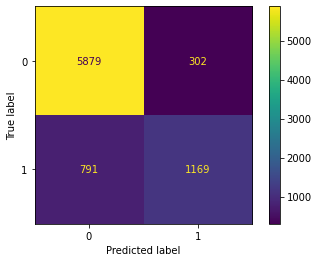


-------------------------------
Datos de ejecución:
CPU times: user 7.75 s, sys: 18 ms, total: 7.77 s
Wall time: 8 s


In [60]:
%%time
#**Instanciar el modelo**
pot_gradiente = GradientBoostingClassifier(random_state=42)
#**Instanciar pipeline**
pot_gradiente_pipe = make_pipeline(pot_gradiente)
#**Ajustar pipeline / modelo a los datos de entrenamiento**
pot_gradiente_pipe.fit(X_train_processed,y_train)
#**Predecir valores y ver tiempo de ejecución**
pot_gradiente_predicciones = pot_gradiente_pipe.predict(X_test_processed)
print(f'Predicciones: {pot_gradiente_predicciones}\n-------------------------------')
#**Evaluar modelo**
print(classification_report(y_test,pot_gradiente_predicciones),'\n-------------------------------')
#**AUC ROC**
print(f'AUC ROC de entrenamiento: {roc_auc_score(y_train,pot_gradiente_pipe.predict_proba(X_train_processed)[:,1])}')
print(f'AUC ROC de prueba: {roc_auc_score(y_test,pot_gradiente_pipe.predict_proba(X_test_processed)[:,1])}')
#**Matriz de confusión**
print('\n-------------------------------','Matriz de confusión:\n',plot_confusion_matrix(pot_gradiente_pipe,X_test_processed,y_test))
plt.show()
print('\n-------------------------------\nDatos de ejecución:')

#####**Optimización de hiperparámetros**

**Obtención de los parámetros actuales del modelo**

In [70]:
pot_gradiente_pipe.get_params()

{'memory': None,
 'steps': [('gradientboostingclassifier',
   GradientBoostingClassifier(max_depth=5, random_state=42))],
 'verbose': False,
 'gradientboostingclassifier': GradientBoostingClassifier(max_depth=5, random_state=42),
 'gradientboostingclassifier__ccp_alpha': 0.0,
 'gradientboostingclassifier__criterion': 'friedman_mse',
 'gradientboostingclassifier__init': None,
 'gradientboostingclassifier__learning_rate': 0.1,
 'gradientboostingclassifier__loss': 'deviance',
 'gradientboostingclassifier__max_depth': 5,
 'gradientboostingclassifier__max_features': None,
 'gradientboostingclassifier__max_leaf_nodes': None,
 'gradientboostingclassifier__min_impurity_decrease': 0.0,
 'gradientboostingclassifier__min_samples_leaf': 1,
 'gradientboostingclassifier__min_samples_split': 2,
 'gradientboostingclassifier__min_weight_fraction_leaf': 0.0,
 'gradientboostingclassifier__n_estimators': 100,
 'gradientboostingclassifier__n_iter_no_change': None,
 'gradientboostingclassifier__random_state

**GridSearch**

In [87]:
grip_params = {
    'max_depth': [3,4,5,6],
    'n_estimators': [50,100,150]
}

grid = GridSearchCV(pot_gradiente, grip_params, cv=5)
grid.fit(X_train_processed,y_train)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=7, random_state=42),
             param_grid={'max_depth': [3, 4, 5, 6],
                         'n_estimators': [50, 100, 150]})

In [93]:
grid.best_params_

{'max_depth': 4, 'n_estimators': 150}

Primera ronda de validación de mejores estimadores:

{'max_depth': 5, 'n_estimators': 100}

La segunda ronda de validación de mejores estimadores vuelve a indicar:

{'max_depth': 5, 'n_estimators': 100}

La tercera ronda indica:

{'max_depth': 4, 'n_estimators': 150}

Predicciones: [0 0 0 ... 0 0 0]
-------------------------------
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6181
           1       0.79      0.64      0.71      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.79      0.81      8141
weighted avg       0.87      0.87      0.87      8141
 
-------------------------------
AUC ROC de entrenamiento: 0.9372201237116837
AUC ROC de prueba: 0.9284084868375437

------------------------------- Matriz de confusión:


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


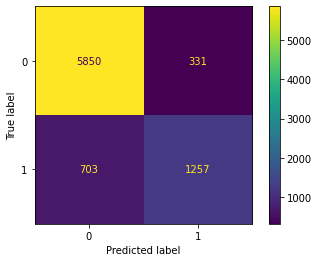


-------------------------------
Datos de ejecución:
CPU times: user 20.4 s, sys: 47.6 ms, total: 20.5 s
Wall time: 21 s


In [94]:
%%time
#**Instanciar el modelo**
pot_gradiente = GradientBoostingClassifier(random_state=42, max_depth=4, n_estimators=150)
#**Instanciar pipeline**
pot_gradiente_pipe = make_pipeline(pot_gradiente)
#**Ajustar pipeline / modelo a los datos de entrenamiento**
pot_gradiente_pipe.fit(X_train_processed,y_train)
#**Predecir valores y ver tiempo de ejecución**
pot_gradiente_predicciones = pot_gradiente_pipe.predict(X_test_processed)
print(f'Predicciones: {pot_gradiente_predicciones}\n-------------------------------')
#**Evaluar modelo**
print(classification_report(y_test,pot_gradiente_predicciones),'\n-------------------------------')
#**AUC ROC**
print(f'AUC ROC de entrenamiento: {roc_auc_score(y_train,pot_gradiente_pipe.predict_proba(X_train_processed)[:,1])}')
print(f'AUC ROC de prueba: {roc_auc_score(y_test,pot_gradiente_pipe.predict_proba(X_test_processed)[:,1])}')
#**Matriz de confusión**
print('\n-------------------------------','Matriz de confusión:\n',plot_confusion_matrix(pot_gradiente_pipe,X_test_processed,y_test))
plt.show()
print('\n-------------------------------\nDatos de ejecución:')

####**MODELO BOOSTING: LigthGBM**

Para ver el tiempo de ejecución total del modelo se va a cargar en una sola celda todo el proceso comentado, para ver el tiempo se inicia con la sentencia %%time

Predicciones: [0 0 0 ... 0 0 0]
-------------------------------
              precision    recall  f1-score   support

           0       0.90      0.94      0.92      6181
           1       0.77      0.67      0.72      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.81      0.82      8141
weighted avg       0.87      0.87      0.87      8141
 
-------------------------------
AUC ROC de entrenamiento: 0.9446991892228205
AUC ROC de prueba: 0.9298513548762005

------------------------------- Matriz de confusión:


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


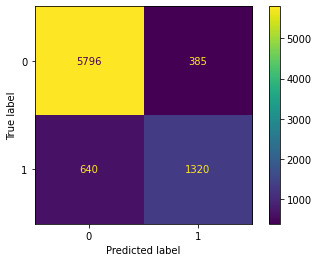


-------------------------------
Datos de ejecución:
CPU times: user 2.33 s, sys: 25.2 ms, total: 2.35 s
Wall time: 1.81 s


In [95]:
%%time
#**Instanciar el modelo**
lgbm = LGBMClassifier(random_state=42)
#**Instanciar pipeline**
lgbm_pipe = make_pipeline(lgbm)
#**Ajustar pipeline / modelo a los datos de entrenamiento**
lgbm_pipe.fit(X_train_processed,y_train)
#**Predecir valores y ver tiempo de ejecución**
lgbm_predicciones = lgbm_pipe.predict(X_test_processed)
print(f'Predicciones: {lgbm_predicciones}\n-------------------------------')
#**Evaluar modelo**
print(classification_report(y_test,lgbm_predicciones),'\n-------------------------------')
#**AUC ROC**
print(f'AUC ROC de entrenamiento: {roc_auc_score(y_train,lgbm_pipe.predict_proba(X_train_processed)[:,1])}')
print(f'AUC ROC de prueba: {roc_auc_score(y_test,lgbm_pipe.predict_proba(X_test_processed)[:,1])}')
#**Matriz de confusión**
print('\n-------------------------------','Matriz de confusión:\n',plot_confusion_matrix(lgbm_pipe,X_test_processed,y_test))
plt.show()
print('\n-------------------------------\nDatos de ejecución:')

#####**Optimización de hiperparámetros**

**Obtención de los parámetros actuales del modelo**

In [96]:
lgbm_pipe.get_params()

{'memory': None,
 'steps': [('lgbmclassifier', LGBMClassifier(random_state=42))],
 'verbose': False,
 'lgbmclassifier': LGBMClassifier(random_state=42),
 'lgbmclassifier__boosting_type': 'gbdt',
 'lgbmclassifier__class_weight': None,
 'lgbmclassifier__colsample_bytree': 1.0,
 'lgbmclassifier__importance_type': 'split',
 'lgbmclassifier__learning_rate': 0.1,
 'lgbmclassifier__max_depth': -1,
 'lgbmclassifier__min_child_samples': 20,
 'lgbmclassifier__min_child_weight': 0.001,
 'lgbmclassifier__min_split_gain': 0.0,
 'lgbmclassifier__n_estimators': 100,
 'lgbmclassifier__n_jobs': -1,
 'lgbmclassifier__num_leaves': 31,
 'lgbmclassifier__objective': None,
 'lgbmclassifier__random_state': 42,
 'lgbmclassifier__reg_alpha': 0.0,
 'lgbmclassifier__reg_lambda': 0.0,
 'lgbmclassifier__silent': True,
 'lgbmclassifier__subsample': 1.0,
 'lgbmclassifier__subsample_for_bin': 200000,
 'lgbmclassifier__subsample_freq': 0}

**GridSearch**

In [110]:
grip_params = {
    'max_depth': [3,5,7],
    'n_estimators': [300,350,400]
}

grid = GridSearchCV(lgbm, grip_params, cv=5)
grid.fit(X_train_processed,y_train)

GridSearchCV(cv=5,
             estimator=LGBMClassifier(max_depth=5, n_estimators=300,
                                      random_state=42),
             param_grid={'max_depth': [3, 5, 7],
                         'n_estimators': [300, 350, 400]})

In [111]:
grid.best_params_

{'max_depth': 3, 'n_estimators': 350}

Primera ronda de validación de mejores estimadores:

{'max_depth': 5, 'n_estimators': 300}

La segunda ronda de validación de mejores estimadores vuelve a indicar:

{'max_depth': 5, 'n_estimators': 350}

La tercera ronda indica:

{'max_depth': 3, 'n_estimators': 350}

Predicciones: [0 0 0 ... 0 0 0]
-------------------------------
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6181
           1       0.79      0.65      0.71      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.80      0.82      8141
weighted avg       0.87      0.87      0.87      8141
 
-------------------------------
AUC ROC de entrenamiento: 0.936544204724776
AUC ROC de prueba: 0.9305932597921875


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



------------------------------- Matriz de confusión:


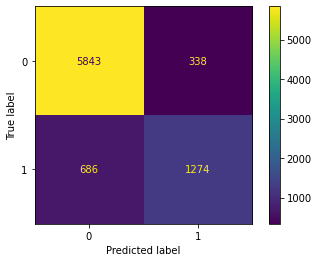


-------------------------------
Datos de ejecución:
CPU times: user 4.58 s, sys: 36.7 ms, total: 4.62 s
Wall time: 4.42 s


In [114]:
%%time
#**Instanciar el modelo**
lgbm = LGBMClassifier(random_state=42, max_depth=3, n_estimators=350)
#**Instanciar pipeline**
lgbm_pipe = make_pipeline(lgbm)
#**Ajustar pipeline / modelo a los datos de entrenamiento**
lgbm_pipe.fit(X_train_processed,y_train)
#**Predecir valores y ver tiempo de ejecución**
lgbm_predicciones = lgbm_pipe.predict(X_test_processed)
print(f'Predicciones: {lgbm_predicciones}\n-------------------------------')
#**Evaluar modelo**
print(classification_report(y_test,lgbm_predicciones),'\n-------------------------------')
#**AUC ROC**
print(f'AUC ROC de entrenamiento: {roc_auc_score(y_train,lgbm_pipe.predict_proba(X_train_processed)[:,1])}')
print(f'AUC ROC de prueba: {roc_auc_score(y_test,lgbm_pipe.predict_proba(X_test_processed)[:,1])}')
#**Matriz de confusión**
print('\n-------------------------------','Matriz de confusión:\n',plot_confusion_matrix(lgbm_pipe,X_test_processed,y_test))
plt.show()
print('\n-------------------------------\nDatos de ejecución:')

####**MODELO BOOSTING: XGBoost**

Para ver el tiempo de ejecución total del modelo se va a cargar en una sola celda todo el proceso comentado, para ver el tiempo se inicia con la sentencia %%time

Predicciones: [0 0 0 ... 0 0 0]
-------------------------------
              precision    recall  f1-score   support

           0       0.88      0.95      0.91      6181
           1       0.80      0.58      0.67      1960

    accuracy                           0.86      8141
   macro avg       0.84      0.77      0.79      8141
weighted avg       0.86      0.86      0.86      8141
 
-------------------------------
AUC ROC de entrenamiento: 0.9215322984559386
AUC ROC de prueba: 0.9204086172569659


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



------------------------------- Matriz de confusión:


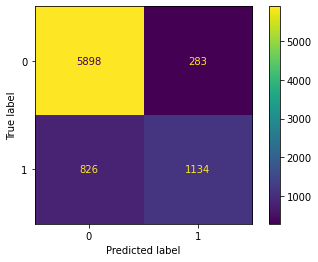


-------------------------------
Datos de ejecución:
CPU times: user 8.22 s, sys: 143 ms, total: 8.37 s
Wall time: 9.31 s


In [115]:
%%time
#**Instanciar el modelo**
xgb = XGBClassifier(random_state=42)
#**Instanciar pipeline**
xgb_pipe = make_pipeline(xgb)
#**Ajustar pipeline / modelo a los datos de entrenamiento**
xgb_pipe.fit(X_train_processed,y_train)
#**Predecir valores y ver tiempo de ejecución**
xgb_predicciones = xgb_pipe.predict(X_test_processed)
print(f'Predicciones: {xgb_predicciones}\n-------------------------------')
#**Evaluar modelo**
print(classification_report(y_test,xgb_predicciones),'\n-------------------------------')
#**AUC ROC**
print(f'AUC ROC de entrenamiento: {roc_auc_score(y_train,xgb_pipe.predict_proba(X_train_processed)[:,1])}')
print(f'AUC ROC de prueba: {roc_auc_score(y_test,xgb_pipe.predict_proba(X_test_processed)[:,1])}')
#**Matriz de confusión**
print('\n-------------------------------','Matriz de confusión:\n',plot_confusion_matrix(xgb_pipe,X_test_processed,y_test))
plt.show()
print('\n-------------------------------\nDatos de ejecución:')

#####**Optimización de hiperparámetros**

**Obtención de los parámetros actuales del modelo**

In [116]:
xgb_pipe.get_params()

{'memory': None,
 'steps': [('xgbclassifier', XGBClassifier(random_state=42))],
 'verbose': False,
 'xgbclassifier': XGBClassifier(random_state=42),
 'xgbclassifier__base_score': 0.5,
 'xgbclassifier__booster': 'gbtree',
 'xgbclassifier__colsample_bylevel': 1,
 'xgbclassifier__colsample_bynode': 1,
 'xgbclassifier__colsample_bytree': 1,
 'xgbclassifier__gamma': 0,
 'xgbclassifier__learning_rate': 0.1,
 'xgbclassifier__max_delta_step': 0,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__min_child_weight': 1,
 'xgbclassifier__missing': None,
 'xgbclassifier__n_estimators': 100,
 'xgbclassifier__n_jobs': 1,
 'xgbclassifier__nthread': None,
 'xgbclassifier__objective': 'binary:logistic',
 'xgbclassifier__random_state': 42,
 'xgbclassifier__reg_alpha': 0,
 'xgbclassifier__reg_lambda': 1,
 'xgbclassifier__scale_pos_weight': 1,
 'xgbclassifier__seed': None,
 'xgbclassifier__silent': None,
 'xgbclassifier__subsample': 1,
 'xgbclassifier__verbosity': 1}

**GridSearch**

In [117]:
grip_params = {
    'max_depth': [1,5,10],
    'n_estimators': [100,200,500]
}

grid = GridSearchCV(lgbm, grip_params, cv=5)
grid.fit(X_train_processed,y_train)

GridSearchCV(cv=5,
             estimator=LGBMClassifier(max_depth=3, n_estimators=350,
                                      random_state=42),
             param_grid={'max_depth': [1, 5, 10],
                         'n_estimators': [100, 200, 500]})

In [118]:
grid.best_params_

{'max_depth': 5, 'n_estimators': 200}

Primera ronda de validación de mejores estimadores:

{'max_depth': 5, 'n_estimators': 200}

La segunda ronda de validación de mejores estimadores vuelve a indicar:

{'max_depth': 5, 'n_estimators': 350}

La tercera ronda indica:

{'max_depth': 3, 'n_estimators': 350}

Predicciones: [0 0 0 ... 0 0 0]
-------------------------------
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      6181
           1       0.79      0.65      0.71      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.80      0.82      8141
weighted avg       0.87      0.87      0.87      8141
 
-------------------------------
AUC ROC de entrenamiento: 0.9424761794139238
AUC ROC de prueba: 0.9309015201291647


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)



------------------------------- Matriz de confusión:


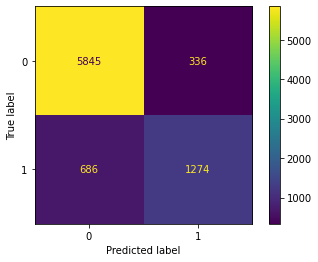


-------------------------------
Datos de ejecución:
CPU times: user 21.4 s, sys: 155 ms, total: 21.6 s
Wall time: 22.3 s


In [119]:
%%time
#**Instanciar el modelo**
xgb = XGBClassifier(random_state=42, max_depth=5,n_estimators=200)
#**Instanciar pipeline**
xgb_pipe = make_pipeline(xgb)
#**Ajustar pipeline / modelo a los datos de entrenamiento**
xgb_pipe.fit(X_train_processed,y_train)
#**Predecir valores y ver tiempo de ejecución**
xgb_predicciones = xgb_pipe.predict(X_test_processed)
print(f'Predicciones: {xgb_predicciones}\n-------------------------------')
#**Evaluar modelo**
print(classification_report(y_test,xgb_predicciones),'\n-------------------------------')
#**AUC ROC**
print(f'AUC ROC de entrenamiento: {roc_auc_score(y_train,xgb_pipe.predict_proba(X_train_processed)[:,1])}')
print(f'AUC ROC de prueba: {roc_auc_score(y_test,xgb_pipe.predict_proba(X_test_processed)[:,1])}')
#**Matriz de confusión**
print('\n-------------------------------','Matriz de confusión:\n',plot_confusion_matrix(xgb_pipe,X_test_processed,y_test))
plt.show()
print('\n-------------------------------\nDatos de ejecución:')